In [1]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *
from arcolanche.transfer_entropy_func import iter_polygon_pair
from arcolanche.self_loop_entropy_func import iter_valid_polygons

from utils_CB import get_coarsegrained, get_ids_from_centroid, plot_cells
from math import factorial

from scipy.sparse import lil_matrix, csr_matrix

Cells in subset: 18
Possible tuples in subset of size 2: 306.0
dt: 32, dx: 453 gridix: 3


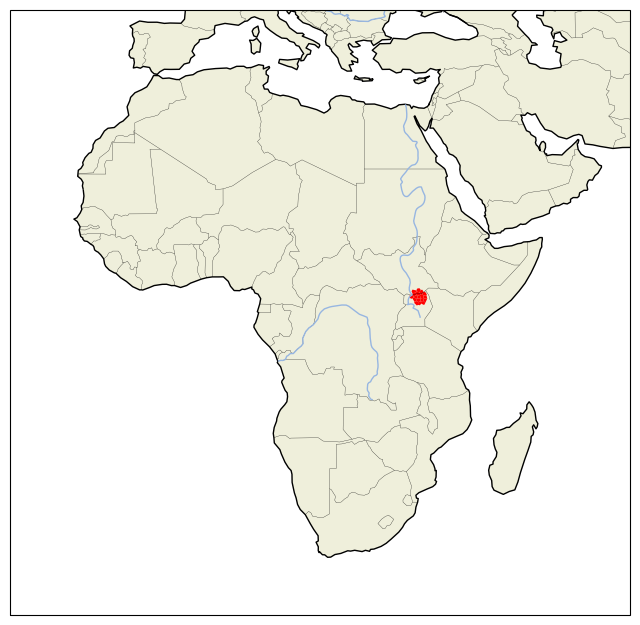

In [2]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)
dt, dx, gridix = mesoscale

load_pickle(f"avalanches/{conflict_type}/gridix_{gridix}/te/conflict_ev_{str(dt)}_{str(dx)}.p")
count_ts = get_coarsegrained(conflict_type, scale = mesoscale, binary=True)

polygons = load_voronoi(dx, gridix) 

size = 2
#degree = 2
centroid = 7311 #counts: 218 
cell_ids = get_ids_from_centroid(polygons, size= size, centroid = 7311)
print("Cells in subset:", len(cell_ids))


def binomial(n, k):
#number of unique k sets in n
    return (factorial(n)/(factorial(k)*factorial(n-k)))

print(f"Possible tuples in subset of size {size}:", binomial(len(cell_ids), 2)*2)

plot_cells(cell_ids, mesoscale, conflict_type, verbose=False)

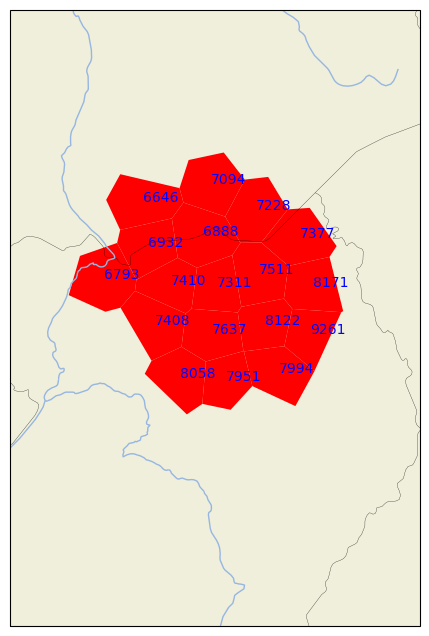

In [3]:
# Zoom in
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Specify polygon and event here
for i, x in enumerate(cell_ids):
    poly = polygons.loc[[x]]
    poly.plot(ax=ax, color="red")
    
    # Get the centroid of the polygon
    centroid = poly.geometry.centroid.iloc[0]
    # Place the index of the polygon as text on the map
    ax.text(centroid.x, centroid.y, str(x), color='blue', transform=ccrs.Geodetic())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAND)   
ax.add_feature(cfeature.RIVERS)

# Zoom in on Kenya, South Sudan, and Uganda

ax.set_extent([31, 35, 0, 6], crs=ccrs.PlateCarree())

plt.show()

In [12]:
def calculate_significant_edges(self_edges, pair_edges, summary = False):
        
    significant_edges = [[] for _ in range(degree+1)]
    counts = np.zeros(degree+1)
    
    #self edges
    for poly, (te, te_shuffle) in self_edges.items():
        if (te > te_shuffle).mean() >= (95 / 100):
            significant_edges[0].append([(poly, poly), te])
    counts[0] = len(self_edges)

    #pair edges
    for pair, (te, te_shuffle) in pair_edges.items():
        d = pair[2]
        if 1 <= d <= degree:
            counts[d] += 1
            if (te > te_shuffle).mean() >= (95/100): #threshold!
                significant_edges[d].append([(pair[0], pair[1]), te])            
    
    #ratio dataframe 
    if summary:
        df = pd.DataFrame(
            {
                "Degree": np.arange(degree+1),
                "Total edges": counts,
                "Significant edges": [len(edges) for edges in significant_edges],
            }
        )
        df["Ratio"] = round(df["Significant edges"] / df["Total edges"], 3)
        
        return df, significant_edges
    
    else:
        return significant_edges

In [16]:
#first degree neighbors
degree = 1
ava_1 = Avalanche(dt = dt, dx = dx, gridix=gridix, size = 16, degree = degree, triples=False, setup=True)
ava_1_self = ava_1.self_edges
ava_1_pair = ava_1.pair_edges

df_1, sign_edges = calculate_significant_edges(ava_1_self, ava_1_pair, summary = True)

#triples
ava_2 = Avalanche(dt = dt, dx = dx, gridix=gridix, size = 16, degree = degree, triples=True, setup=True)
ava_2_self = ava_2.self_edges
ava_2_pair = ava_2.pair_edges

#pair edges
significant_triples = []
for triplet, (te, te_shuffle) in ava_2_pair.items():
    if (te > te_shuffle).mean() >= (95/100): #threshold!
        significant_triples.append([(triplet[0], triplet[1], triplet[2]), te])            

print(df_1)
print(len(significant_triples)/len(ava_2_pair))

#todo: compare transfer entropies


/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


   Degree  Total edges  Significant edges  Ratio
0       0        606.0                181  0.299
1       1       2674.0                447  0.167
0.2752420470262794
